In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geoopt
import torch

In [3]:
from embedders.manifolds import Manifold, ProductManifold

In [4]:
m_h = Manifold(-1, 4)
m_h.sample([[1, 0, 0, 0, 0] * 3])

tensor([[ 5.0813,  0.9624,  3.8158, -2.1871, -2.1330],
        [ 2.1566,  0.2668, -0.5645, -0.5269, -1.7272],
        [ 2.4415,  0.4183,  0.8918, -1.9882,  0.1945]], grad_fn=<CatBackward0>)

In [5]:
m_e = Manifold(0, 4)
m_e.sample([[1, 0, 0, 0] * 3])

tensor([[ 2.0238, -0.9392,  0.0836, -0.2936],
        [ 0.9083, -1.3092,  1.3348,  1.1955],
        [ 2.4038, -1.8374,  1.2316, -0.5896]], grad_fn=<AddBackward0>)

In [6]:
m_s = Manifold(1, 4)
m_s.sample([[1, 0, 0, 0, 0] * 4])

tensor([[-1.4558e-01,  6.0445e-01, -6.7458e-01,  2.8390e-01,  2.7893e-01],
        [-7.5116e-01,  4.3597e-03, -7.0040e-02, -5.8723e-01,  2.9324e-01],
        [-4.8648e-01, -4.5891e-01, -7.1782e-01, -9.5319e-03, -1.9332e-01],
        [-9.9488e-01, -5.8464e-02, -9.3431e-04,  5.5398e-02,  6.0982e-02]],
       grad_fn=<WhereBackward0>)

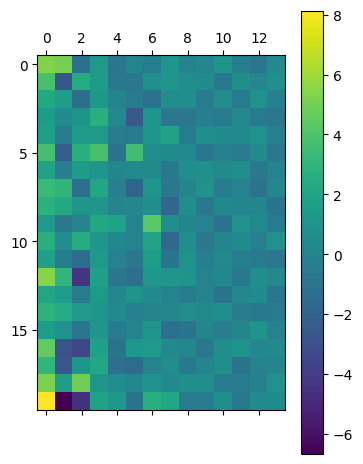

In [7]:
import matplotlib.pyplot as plt

signature = [(-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2)]
pm = ProductManifold(signature)

z_sample = pm.sample([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0] * 20)

plt.matshow(z_sample.detach().numpy().reshape(20, 14))
plt.colorbar()
plt.show()

-4
-2
-1.0
-0.5
0
0.5
1.0
2.0
4.0


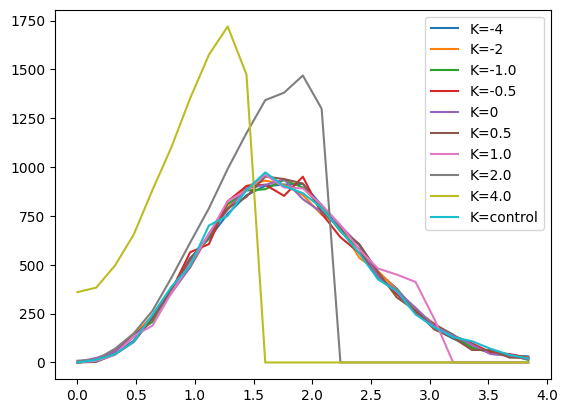

In [30]:
# Sanity check: can we get the right distribution of samples for different scales?

N_SAMPLES = 10_000

all_dists = {}
for K in [-4, -2, -1.0, -0.5, 0, 0.5, 1.0, 2.0, 4.0]:
    print(K)
    m = Manifold(K, 4)
    samples = m.sample(torch.cat([m.mu0] * N_SAMPLES, dim=0))
    dists = m.dist(m.mu0, samples)
    all_dists[K] = dists

all_dists["control"] = torch.norm(torch.randn(size=(N_SAMPLES, 4)), dim=1)

# Get histograms with torch and line-plot them
for K, dists in all_dists.items():
    dist_hist = torch.histogram(dists, bins=25, range=(0, 4))
    plt.plot(dist_hist.bin_edges[:-1].detach().cpu().numpy(), dist_hist.hist.detach().cpu().numpy(), label=f"K={K}")
plt.legend()

# Great, this looks right: all distances match, except where we totally run out of space on our manifold
# (e.g. K=2; K=1 is starting to curve off a little bit near d=pi...)

In [17]:
m.dist(m.mu0.unsqueeze(0), samples)

tensor([[0.6538, 1.3050, 1.0579,  ..., 2.3996, 1.1247, 3.0623]],
       grad_fn=<MulBackward0>)

In [11]:
m.mu0

tensor([1., 0., 0., 0., 0.])

In [12]:
samples

tensor([[  1.4587,   0.5312,   0.6928,   0.3387,   0.5010],
        [  3.2447,  -0.7038,  -1.1650,   1.4763,  -2.3443],
        [  2.3442,   0.7102,  -0.2683,  -1.9790,   0.0495],
        ...,
        [ 14.9022,  -2.0632,  -7.4561,  11.7306,  -4.8600],
        [  2.5552,  -0.7210,   0.7963,  -1.9198,  -0.8304],
        [ 38.0077, -35.2603,   9.5145,  10.4653,  -0.4969]],
       grad_fn=<CatBackward0>)

In [151]:
# Verify that log-likelihood functions work:

for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = Manifold(K, 4)
    # Pick a random point to use as the center
    mu = m.sample(m.mu0)
    Sigma = torch.diag(torch.randn(m.dim)) ** 2
    samples = m.sample(z_mean=torch.cat([mu] * N_SAMPLES, dim=0), sigma=Sigma)
    log_probs_p = m.log_likelihood(z=samples)  # Default args
    log_probs_q = m.log_likelihood(z=samples, mu=mu, sigma=Sigma)
    print(
        f"Shape: {log_probs_p.shape},\tP(z) = {log_probs_p.mean().item():.3f},\tQ(z) = {log_probs_q.mean().item():.3f},\tQ(z) - P(z) = {log_probs_q.mean().item() - log_probs_p.mean().item():.3f}"
    )
    print()

    # Why don't we generally see Q(z) - P(z) > 0? I would think the ll of the true distribution would be higher than the ll of the wrong distribution...

-2
Shape: torch.Size([10000]),	P(z) = -11.171,	Q(z) = -6.691,	Q(z) - P(z) = 4.480

-1.0
Shape: torch.Size([10000]),	P(z) = -14.416,	Q(z) = -3.582,	Q(z) - P(z) = 10.834

-0.5
Shape: torch.Size([10000]),	P(z) = -11.057,	Q(z) = -6.292,	Q(z) - P(z) = 4.765

0
Shape: torch.Size([10000]),	P(z) = -6.323,	Q(z) = 2.038,	Q(z) - P(z) = 8.361

0.5
Shape: torch.Size([10000]),	P(z) = -4.935,	Q(z) = -3.417,	Q(z) - P(z) = 1.519

1.0
Shape: torch.Size([10000]),	P(z) = -3.432,	Q(z) = -2.876,	Q(z) - P(z) = 0.556

2.0
Shape: torch.Size([10000]),	P(z) = -3.006,	Q(z) = -0.851,	Q(z) - P(z) = 2.155



In [176]:
# Does the same thing work with product manifolds?

# Verify that log-likelihood functions work:
for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = ProductManifold(signature=[(K, 4)])
    # Pick a random point to use as the center
    mu = m.sample(m.mu0)
    Sigma = torch.diag(torch.randn(m.dim)) ** 2
    samples = m.sample(z_mean=torch.cat([mu] * N_SAMPLES, dim=0), sigma=Sigma)
    log_probs_p = m.log_likelihood(z=samples)  # Default args
    log_probs_q = m.log_likelihood(z=samples, mu=mu, sigma=Sigma)
    print(
        f"Shape: {log_probs_p.shape},\tP(z) = {log_probs_p.mean().item():.3f},\tQ(z) = {log_probs_q.mean().item():.3f},\tQ(z) - P(z) = {log_probs_q.mean().item() - log_probs_p.mean().item():.3f}"
    )
    print()

    # Why don't we generally see Q(z) - P(z) > 0? I would think the ll of the true distribution would be higher than the ll of the wrong distribution...

-2
Shape: torch.Size([10000]),	P(z) = -8.717,	Q(z) = -2.236,	Q(z) - P(z) = 6.481

-1.0
Shape: torch.Size([10000]),	P(z) = -5.105,	Q(z) = -1.118,	Q(z) - P(z) = 3.988

-0.5
Shape: torch.Size([10000]),	P(z) = -8.549,	Q(z) = -2.814,	Q(z) - P(z) = 5.735

0
Shape: torch.Size([10000]),	P(z) = -8.077,	Q(z) = -0.241,	Q(z) - P(z) = 7.836

0.5
Shape: torch.Size([10000]),	P(z) = -4.328,	Q(z) = -2.567,	Q(z) - P(z) = 1.761

1.0
Shape: torch.Size([10000]),	P(z) = -3.595,	Q(z) = -1.987,	Q(z) - P(z) = 1.607

2.0
Shape: torch.Size([10000]),	P(z) = -3.093,	Q(z) = -1.454,	Q(z) - P(z) = 1.639



In [177]:
# Repeat in a nontrivial manifold

# Verify that log-likelihood functions work:
for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = ProductManifold(signature=[(K, 4), (K, 4), (0, 4)])
    # Pick a random point to use as the center
    mu = m.sample(m.mu0)
    Sigma = torch.diag(torch.randn(m.dim)) ** 2
    samples = m.sample(z_mean=torch.cat([mu] * N_SAMPLES, dim=0), sigma=Sigma)
    log_probs_p = m.log_likelihood(z=samples)  # Default args
    log_probs_q = m.log_likelihood(z=samples, mu=mu, sigma=Sigma)
    print(
        f"Shape: {log_probs_p.shape},\tP(z) = {log_probs_p.mean().item():.3f},\tQ(z) = {log_probs_q.mean().item():.3f},\tQ(z) - P(z) = {log_probs_q.mean().item() - log_probs_p.mean().item():.3f}"
    )
    print()

    # Why don't we generally see Q(z) - P(z) > 0? I would think the ll of the true distribution would be higher than the ll of the wrong distribution...

-2
Shape: torch.Size([10000]),	P(z) = -38.533,	Q(z) = -16.560,	Q(z) - P(z) = 21.973

-1.0
Shape: torch.Size([10000]),	P(z) = -34.410,	Q(z) = -15.230,	Q(z) - P(z) = 19.180

-0.5
Shape: torch.Size([10000]),	P(z) = -18.976,	Q(z) = -4.261,	Q(z) - P(z) = 14.714

0
Shape: torch.Size([10000]),	P(z) = -33.424,	Q(z) = -18.237,	Q(z) - P(z) = 15.188

0.5
Shape: torch.Size([10000]),	P(z) = -16.927,	Q(z) = -17.962,	Q(z) - P(z) = -1.035

1.0
Shape: torch.Size([10000]),	P(z) = -15.064,	Q(z) = -5.486,	Q(z) - P(z) = 9.578

2.0
Shape: torch.Size([10000]),	P(z) = -11.119,	Q(z) = -1.801,	Q(z) - P(z) = 9.318



In [180]:
# Check that KL divergence is working:
from embedders.vae import ProductSpaceVAE

for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    pm = ProductManifold(signature=[(K, 4)])
    # Pick a random point to use as the center
    mu = pm.sample(pm.mu0)
    Sigma = torch.diag(torch.randn(pm.dim)) ** 2

    pm = product_manifold = ProductManifold(signature=[(K, 4)])
    pvae = ProductSpaceVAE(product_manifold=pm, encoder=None, decoder=None)
    kl = pvae.kl_divergence(z_mean=mu, sigma=Sigma, n_samples=16)
    print(f"KL = {kl.mean().item():.3f}")
    print()

-2
KL = 11.919

-1.0
KL = 11.751

-0.5
KL = 7.699

0
KL = 0.493

0.5
KL = 1.914

1.0
KL = 1.779

2.0
KL = 1.093



In [186]:
pm.ambient_dim

5